In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
raw = pd.read_csv("Data/student-por.csv", sep = ";")

In [3]:
def onehot_encode(data, var):
    encode = pd.get_dummies(raw[var])
    for label in raw[var].unique():
        data[f'{var}_{label}'] = encode[label]
    data.drop(var, axis = 1, inplace = True)

In [4]:
# onehot encode
data = raw.copy()
for var in raw.columns:
    if type(raw[var][0]) == str:
        onehot_encode(data, var)

In [5]:
data.head()
# 59 columns

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_yes,nursery_no,higher_yes,higher_no,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,1,0,1,0,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,0,1,1,0,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,1,0,1,0,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,1,0,1,0,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,1,0,1,0,1,0,1,0


# Binary Classification. 
G3 >= 10 : Pass\
G3 < 10 : Fail

In [6]:
data['G3'] = [1 if data['G3'][i] >= 10 else 0 for i in range(len(data['G3']))]

In [7]:
y = data['G3']
X_A = data.drop(['G3','G1','G2'], axis = 1)  
X_B = data.drop(['G3'], axis = 1)

In [8]:
def feature_select(X, y, max_features = None, threshold = None):
    selection = SelectFromModel(ExtraTreesClassifier(n_estimators = 200), max_features = max_features, threshold = threshold)
    selection.fit(X, y)
    selection.get_support()
    
    selected_feat= X.columns[(selection.get_support())]
    #print(len(selected_feat), selected_feat)
    
    X = selection.transform(X)
    return X, selected_feat

def show_selection(X, y, n_selection):
    forest = ExtraTreesClassifier(n_estimators=200,
                              random_state=0)
    forest.fit(X,y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(n_selection):
        print(f'{f+1}. {X.columns[indices[f]]} ({importances[indices[f]]})')
    plt.figure(figsize=(25,10))
    plt.title("Feature importances with std")
    indices = indices[:n_selection]
    plt.bar(range(n_selection), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(n_selection), [X.columns[i] for i in indices])
    plt.xlim([-1, n_selection])
    plt.show()

Feature ranking:
1. failures (0.07784285188710639)
2. higher_no (0.039726136964351025)
3. school_MS (0.03620751840812759)
4. higher_yes (0.036124894167861576)
5. school_GP (0.03585459643514959)
6. absences (0.03494733869490345)
7. famrel (0.02985619850988359)
8. Walc (0.02722461942147895)
9. goout (0.026389703036367423)
10. freetime (0.026041627520331227)
11. traveltime (0.025233424474760433)
12. Fedu (0.025113229931519716)
13. health (0.02439643963918862)
14. Dalc (0.023470295266381794)
15. age (0.02308369161805511)
16. Medu (0.022226481704182382)
17. studytime (0.02011471444342348)
18. reason_course (0.01852693160748503)


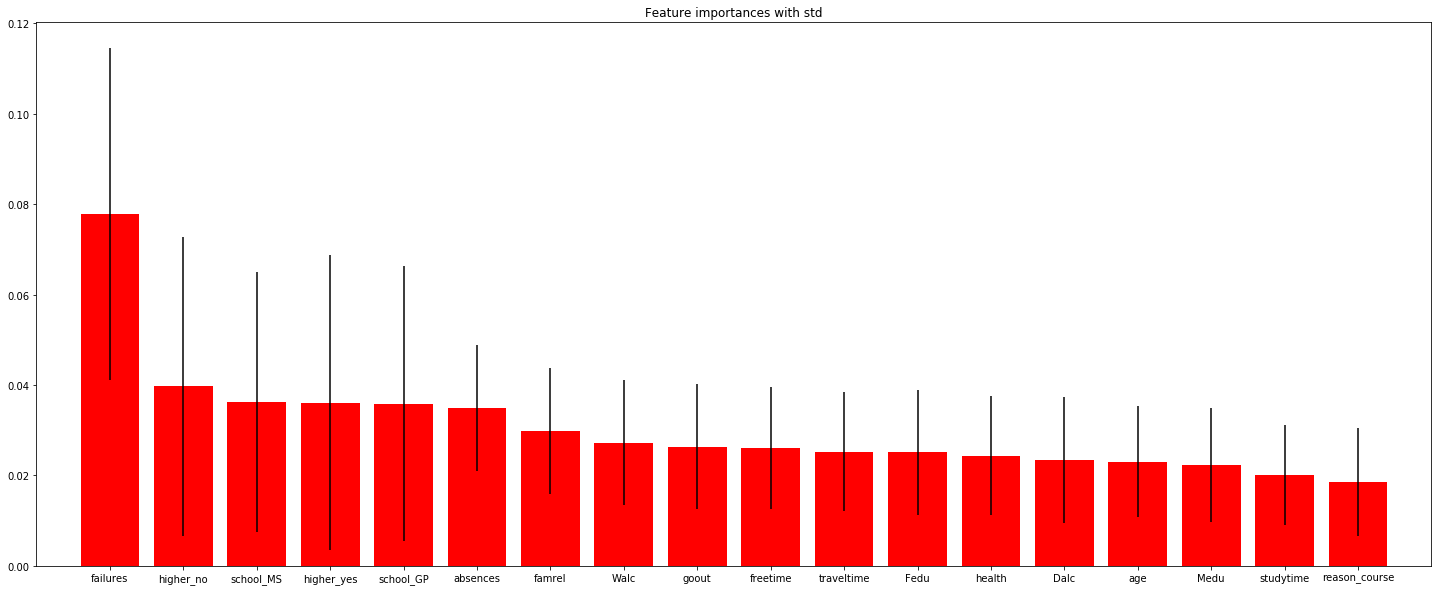

In [9]:
X, selected_feat = feature_select(X_A, y)
show_selection(X_A,y, X.shape[1])

Feature ranking:
1. G2 (0.12717592039694928)
2. G1 (0.1113089238488579)
3. failures (0.05993962355340404)
4. higher_yes (0.034079385171477655)
5. school_MS (0.033837779248405295)
6. higher_no (0.027592692464246553)
7. school_GP (0.02749135612787446)
8. famrel (0.02510014950486332)
9. absences (0.022871808542425726)
10. goout (0.019161596651036363)
11. freetime (0.019121047134028773)
12. traveltime (0.018269684031320226)
13. Medu (0.01806773459114167)
14. Walc (0.017935827413521326)
15. Dalc (0.017423530130051244)


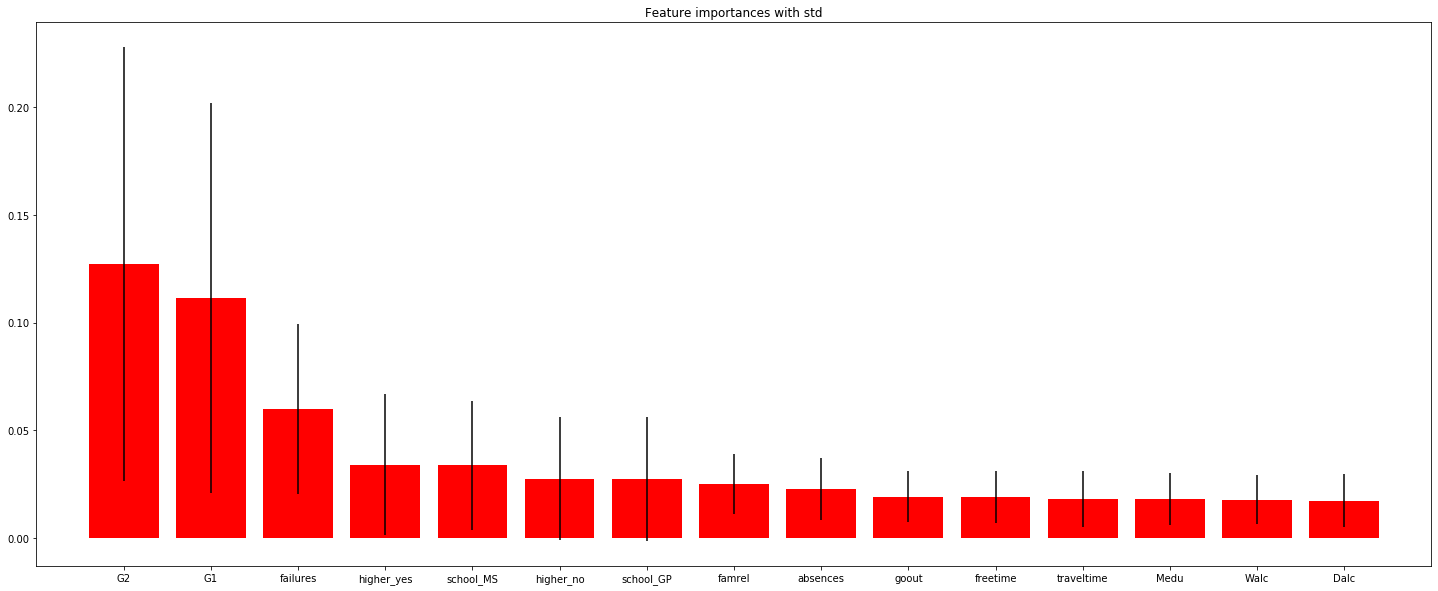

In [10]:
X, selected_feat = feature_select(X_B, y)
show_selection(X_B,y, X.shape[1])

In [11]:
Xa, sel_A = feature_select(X_A, y, threshold = '1.5*mean')
Xb, sel_B = feature_select(X_B, y, threshold = '1.5*mean')
sel_A, sel_B

(Index(['failures', 'famrel', 'goout', 'Walc', 'absences', 'school_GP',
        'school_MS', 'higher_yes', 'higher_no'],
       dtype='object'),
 Index(['failures', 'G1', 'G2', 'school_GP', 'school_MS', 'higher_yes',
        'higher_no'],
       dtype='object'))

# Model Selection - Classification

In [12]:
CV = 10
SCORING = 'accuracy'#'precision'
def myCV(model, X, y, cv = CV, scoring = SCORING):
    cv_results = cross_validate(model, X, y, cv = cv, scoring = scoring)
    scores = cv_results['test_score']
    
    return np.max(scores), np.min(scores), np.mean(scores), np.median(scores)

def report(_max, _min, mean, median):
    print(f'max: {_max}, min: {_min}')
    print(f'mean: {mean}, median: {median}')
    
def plot(select_function, tune_range, x_label, nfolds = CV, scoring = SCORING):
    fig, ax = plt.subplots(1, 2 ,figsize = (20,5))
    plt.setp(ax, xticks=range(len(tune_range)), xticklabels=tune_range)

    lmax, lmin, lmean, lmedian = select_function(tune_range, Xa, y, nfolds = nfolds, scoring = scoring)
    print(f'mean best:[{lmean.index(max(lmean))}], median best:[{lmedian.index(max(lmedian))}]')
    report(max(lmax), max(lmin), max(lmean), max(lmedian))
    ax[0].plot(lmax, label = 'A_max')
    ax[0].plot(lmin,label = 'A_min')
    ax[0].plot(lmean, label = 'A_mean')
    ax[0].plot(lmedian, label = 'A_median')
    ax[0].legend(); ax[0].set_title('Data A after Selection - Precision'); ax[0].set_xlabel(x_label)
    resultA = (max(lmean), np.std(lmean), tune_range[lmean.index(max(lmean))])

    lmax, lmin, lmean, lmedian = select_function(tune_range, Xb, y, nfolds = nfolds, scoring = scoring)
    print(f'mean best:[{lmean.index(max(lmean))}], median best:[{lmedian.index(max(lmedian))}]')
    report(max(lmax), max(lmin), max(lmean), max(lmedian))
    ax[1].plot(lmax, label = 'B_max')
    ax[1].plot(lmin,label = 'B_min')
    ax[1].plot(lmean, label = 'B_mean')
    ax[1].plot(lmedian, label = 'B_median')
    ax[1].legend(); ax[1].set_title('Data B after Selection - Precision'); ax[1].set_xlabel(x_label)
    resultB = (max(lmean), np.std(lmean), tune_range[lmean.index(max(lmean))])
    
    plt.show()
    return resultA, resultB

# KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
def model_select_KNN(krange, X, y, nfolds, scoring):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for k in krange:
        model = KNeighborsClassifier(n_neighbors = k)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

mean best:[16], median best:[2]
max: 0.8923076923076924, min: 0.84375
mean: 0.8489903846153848, median: 0.8461538461538461
mean best:[18], median best:[4]
max: 0.9846153846153847, min: 0.859375
mean: 0.9213221153846154, median: 0.9230769230769231


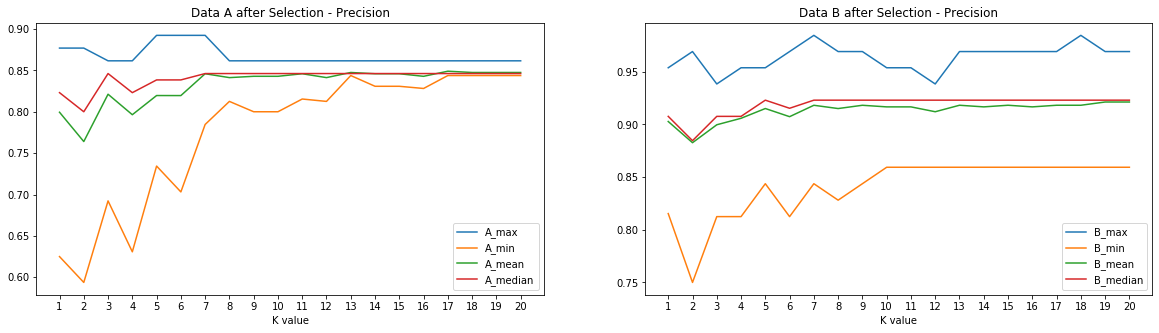

((0.8489903846153848, 0.022260523265824797, 17),
 (0.9213221153846154, 0.009080481914555683, 19))

In [15]:
krange = range(1, 21)

plot(model_select_KNN, krange, 'K value')

# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [17]:
def model_select_DTC(drange, X, y, nfolds, scoring):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for d in drange:
        model = DecisionTreeClassifier(max_depth = d)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

mean best:[2], median best:[2]
max: 0.9230769230769231, min: 0.796875
mean: 0.8488701923076925, median: 0.8615384615384616
mean best:[0], median best:[0]
max: 0.9692307692307692, min: 0.8923076923076924
mean: 0.9368269230769231, median: 0.9384615384615385


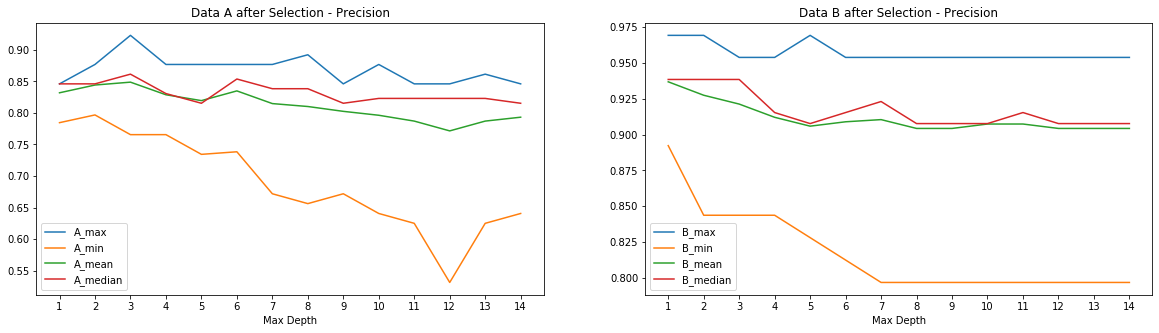

((0.8488701923076925, 0.022739420352061543, 3),
 (0.9368269230769231, 0.009725020835112157, 1))

In [18]:
drange = range(1, 15)

plot(model_select_DTC, drange, 'Max Depth')

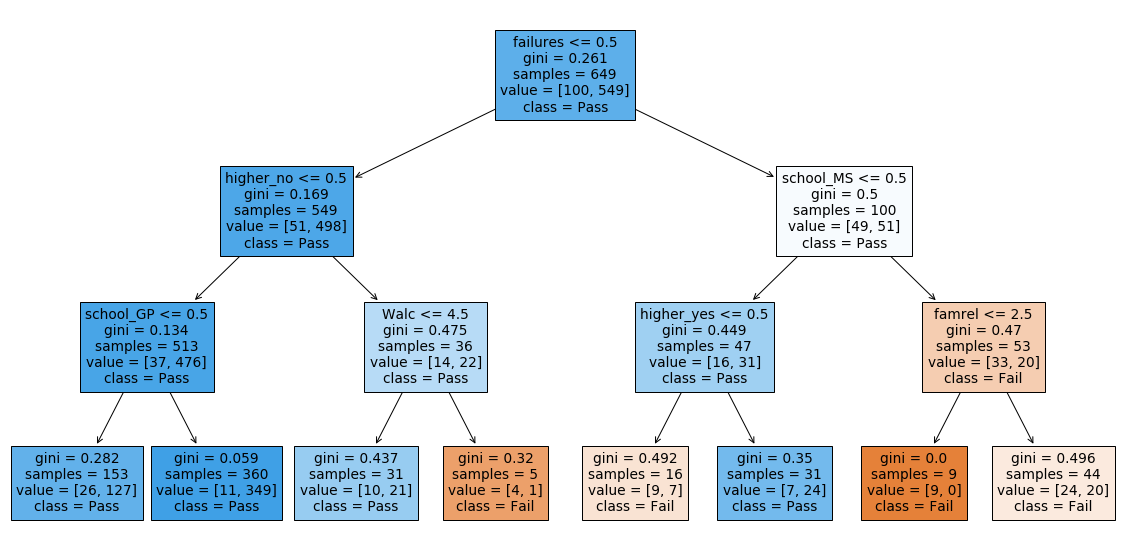

In [19]:
reg_tree = DecisionTreeClassifier(max_depth=3)
reg_tree.fit(Xa, y)

plt.figure(figsize = (20,10))
tree.plot_tree(reg_tree, filled=True, feature_names = sel_A, class_names = ['Fail','Pass'])
plt.show()

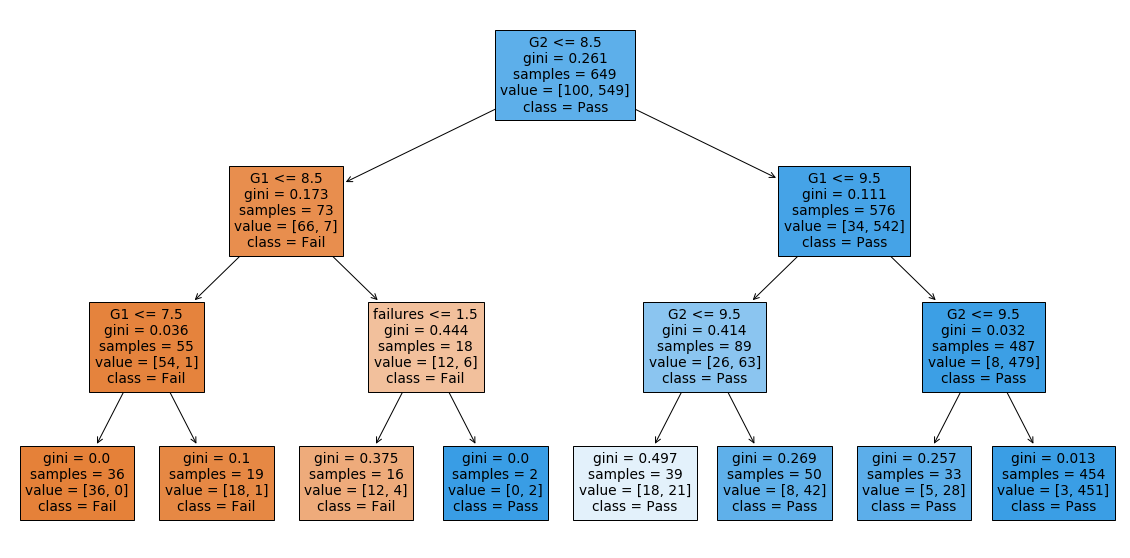

In [20]:
reg_tree = DecisionTreeClassifier(max_depth=3)
reg_tree.fit(Xb, y)

plt.figure(figsize = (20,10))
tree.plot_tree(reg_tree, filled=True, feature_names = sel_B, class_names = ['Fail','Pass'])
plt.show()

# Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
def model_select_RFC(drange, X, y, nfolds, scoring):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for depth in drange:
        model = RandomForestClassifier(max_depth = depth)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

mean best:[2], median best:[2]
max: 0.9230769230769231, min: 0.796875
mean: 0.8488701923076925, median: 0.8615384615384616
mean best:[0], median best:[0]
max: 0.9692307692307692, min: 0.8923076923076924
mean: 0.9368269230769231, median: 0.9384615384615385


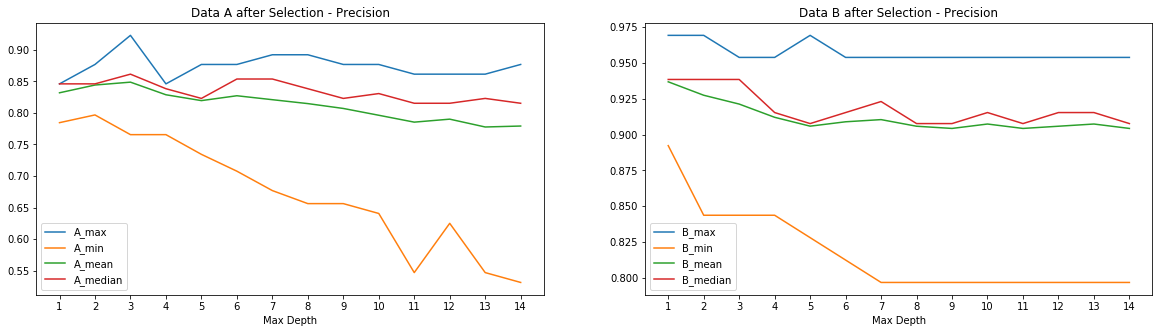

((0.8488701923076925, 0.02261188192643913, 3),
 (0.9368269230769231, 0.009579070241829316, 1))

In [23]:
drange = range(1, 15)

plot(model_select_DTC, drange, 'Max Depth')

# Boosting

In [24]:
from sklearn.ensemble import AdaBoostClassifier

In [25]:
def model_select_Ada(nrange, X, y, nfolds, scoring):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for n in nrange:
        model = AdaBoostClassifier(n_estimators = n)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

mean best:[2], median best:[0]
max: 0.8923076923076924, min: 0.75
mean: 0.8396394230769232, median: 0.8538461538461539
mean best:[0], median best:[0]
max: 0.9846153846153847, min: 0.875
mean: 0.9290384615384616, median: 0.9384615384615385


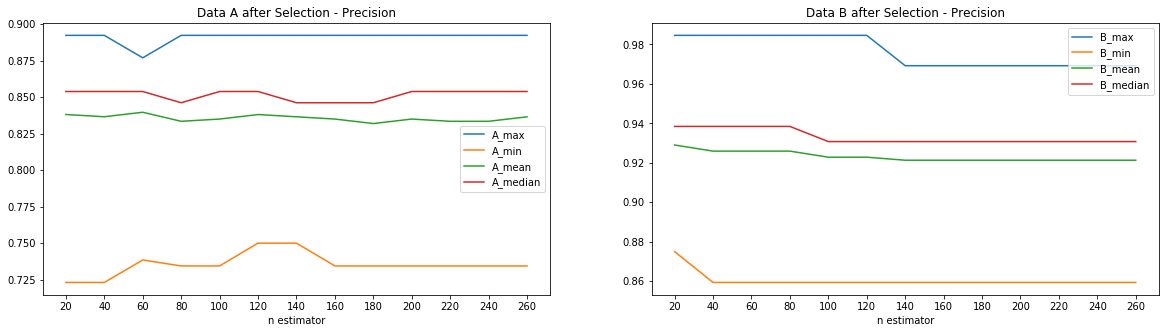

((0.8396394230769232, 0.0021526512017600924, 60),
 (0.9290384615384616, 0.002503550728526683, 20))

In [26]:
nrange = range(20, 261, 20)
plot(model_select_Ada, nrange, 'n estimator')

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
def model_select_GB(nrange, X, y, nfolds, scoring):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for n in nrange:
        model = GradientBoostingClassifier(n_estimators = n, max_depth=4)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

mean best:[0], median best:[0]
max: 0.8923076923076924, min: 0.75
mean: 0.8396153846153848, median: 0.8461538461538461
mean best:[2], median best:[3]
max: 0.9692307692307692, min: 0.859375
mean: 0.9182211538461539, median: 0.9230769230769231


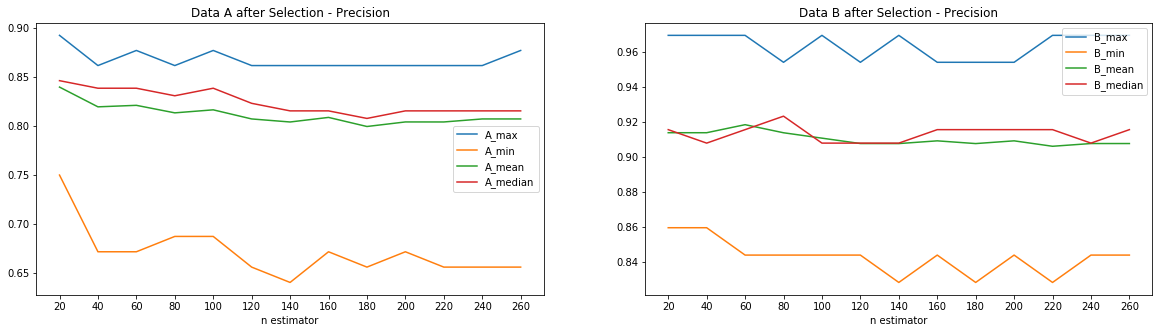

((0.8396153846153848, 0.010177034361725535, 20),
 (0.9182211538461539, 0.0034953527195522496, 60))

In [29]:
plot(model_select_GB, nrange, 'n estimator')